<a href="https://colab.research.google.com/github/mwvgroup/Pitt-Google-Broker/blob/u%2Ftjr%2Ftutorials/pbg_utils/tutorials/PGB_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pitt-Google Broker
---

# Notebook Outline

1. Use Cases (how to navigate this tutorial)
2. Overview: Data storage and access
3. Setup (do this before subsequent sections)
4. Access: Databases (alerts, object histories and lightcurves, cone search)
    



`pgb_utils` is a collection of helper functions for accessing, reading, and processing 

# 1) Use cases

| Use Case or Task | Section |
|---|---|
|1. found an object(s) and you want to get it's history | query db, section 3 |
|2. ~found an object, want to know it's future~ we're not ready |~pubsub~ either a watchlist or model predictions (which Alerce is now doing).|

3. You have found a small group of objects you want to study
    - [sec 
    - you come up with a model and want to look for other objects that are similar: sec 7, use a Beam pipeline to query the db and analyze the results.
    - you refine your model and want to monitor the alert stream for new objects displying similar behavior: sec 7 the Pub/Sub streams 
- don't know the object your looking for. want to do exploration/discover. do the query, then convert to pubsub streams.
    - found 10 91-bg's, found particular type of rise behavior. query db, which 
- michael, statistics on all data.

1. past
2. future
- convert past to future





# 2) Overview: Data storage and access

- Databases are stored in [BigQuery](https://cloud.google.com/bigquery) and can be queried via the command-line, Python and other languages.
- Alert Avro files are stored in [Cloud Storage](https://cloud.google.com/storage) and can be accessed via the command-line, Python and other languages.
- Live alert streams are delivered via [Pub/Sub](https://cloud.google.com/pubsub/docs/overview) and can be accessed via Python.

Specifics (e.g., schemas) are detailed in the relevant sections.

Google provides command-line tools and APIs  in [Python](https://cloud.google.com/python/references/libraries), etc., which you can use to access our data and services.

In addition, we have written a package of Python utilities, `pgb_utils`, which are a collection wrappers for Google's Python API tools and helper functions that give you some options for reading and process the data.
 
Links to more information:
- Working with ZTF alerts: [Filtering_alerts.ipynb](https://github.com/ZwickyTransientFacility/ztf-avro-alert/blob/master/notebooks/Filtering_alerts.ipynb)

---

# 3) Setup

Our data is public, but you need to setup a [Google Cloud Platform](https://cloud.google.com/gcp) (GCP) project so that you can make API calls to Cloud resources.

- Use the [Cloud Resource Manager](https://console.cloud.google.com/cloud-resource-manager) to create a GCP project called "My PGB Project" (or whatever you'd like).
    - A "Project ID" will be generated for you. Copy it and assign it to the variable `my_project_id` in the cell below.
- [Enable billing](https://support.google.com/cloud/answer/6293499#enable-billing) for your project.
    - .
- Enable APIs for your project:
    - [BigQuery](https://console.cloud.google.com/flows/enableapi?apiid=bigquery)

Note: This notebook is intended to run in Google Colab which: 
1. provides an environment pre-configured with most of the libraries we need, and
2. facilitates authentication, avoiding the need to download and configure credentials.

(I should provide users with a little more info about how to connect outside of this notebook.)

In [ ]:
from google.colab import auth

In [ ]:
# Colab Setup
auth.authenticate_user()
# follow the instructions to authorize Google Cloud SDK 

#--- Local machine setup
# [to do]

In [ ]:
my_project_id = 'ardent-cycling-243415'
# my_project_id = 'my-pgb-project'  # ENTER YOUR GCP PROJECT ID HERE
pgb_project_id = 'ardent-cycling-243415'

In [ ]:
# Create a function to run and print a shell command.
def run(cmd: str):
  print('>> {}'.format(cmd))
  !{cmd}
  print('')

In [ ]:
# Install some packages/versions not included with Colab
# 
packages = ['apache-beam','google-apitools','APLpy',
            'beautifulsoup4==4.8',  # plot_cutouts grayscale stretch='arcsinh'
            'astropy-healpix==0.6',  # plot_cutouts grayscale stretch='arcsinh'
            'astropy==3.2.1',  # plot_cutouts grayscale stretch='arcsinh'
            ]
# 'google-cloud-pubsub',] 
# causes:
# `ContextualVersionConflict: (PyYAML 3.13 (/usr/local/lib/python3.7/dist-packages), Requirement.parse('pyyaml>=5.2'), {'libcst'})`
# when importing apache-beam below.
for package in packages:
    run(f'pip install --quiet {package}')
# This may complain that you won't have quite the right distributions of 
# some requirements, but this should not cause problems.

# Note: Outside of Colab you should use `pip install apache-beam[gcp]`
# for the version that includes tools for Google Cloud resources.

>> pip install --quiet apache-beam
     |████████████████████████████████| 9.0MB 5.6MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 153kB 27.3MB/s 
     |████████████████████████████████| 829kB 45.1MB/s 
     |████████████████████████████████| 2.2MB 29.4MB/s 
     |████████████████████████████████| 17.7MB 241kB/s 
     |████████████████████████████████| 61kB 5.7MB/s 
     |████████████████████████████████| 112kB 53.7MB/s 
ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.

>> pip install --quiet google-apitools
     |████████████████████████████████| 174kB 5.5MB/s 

>> pip install --quiet APLpy
     |████████████████████████████████| 92kB 3.6MB/s 
     |██

In [ ]:
# Install the Pitt-Google Broker utilities package
run('python3 -m pip install --index-url https://test.pypi.org/simple/ --no-deps pgb_utils')

# This is currently on the test.pypi servers. I should publish to the actual
# PyPI soon, but I'd like some code review first.

# I have termporarily named this `pgb_utils`, but we should decide on something.

>> python3 -m pip install --index-url https://test.pypi.org/simple/ --no-deps pgb_utils
Looking in indexes: https://test.pypi.org/simple/



In [ ]:
import apache_beam as beam
import aplpy
from astropy.io import fits
import fastavro
from google.colab import drive
import gzip
import io
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
import warnings

from google.cloud import bigquery, storage
# , pubsub

import pgb_utils as pgb

In [ ]:
# Connect your Google Drive file system
drive.mount('/content/drive')  # follow the instructions to authorize access
colabpath = '/content/drive/MyDrive/Colab\ Notebooks/PGB'
colabpath_noesc = '/content/drive/MyDrive/Colab Notebooks/PGB'
run(f'mkdir -p {colabpath}')
# used in the sections on File Storage and Apache Beam pipelines

# Colab Hint: Click the "Files" icon on the left to view a file browser.

# Colab Hint: Click the "Code snippets" icon (<>) on the left and search for 
#       "access drive" to learn how to interact with Drive.

Mounted at /content/drive
>> mkdir -p /content/drive/MyDrive/Colab\ Notebooks/PGB



---

# 4) Databases (BigQuery)

We currently have the following database tables available to query (format: `dataset.table`):
- `ztf_alerts.alerts`
-`ztf_alerts.salt2`

They are stored in [BigQuery](https://cloud.google.com/bigquery) and contain data since ~Nov 2020.
Their schemas can be viewed using the code below. 
They can be queried using standard SQL from the command-line, Python, Java and other languages.
In this tutorial, we will demonstrate the following methods: 1) Python, including `pgb_utils` tools that facilitate access, and 2) command-line. 

Links to more information:
- [Overview of querying BigQuery data](https://cloud.google.com/bigquery/docs/query-overview)


- [BigQuery How-to guides](https://cloud.google.com/bigquery/docs/how-to). There are many! Here are some of note:

    - [Introduction to interacting with BigQuery](https://cloud.google.com/bigquery/docs/interacting-with-bigquery)

    - [Queries](https://cloud.google.com/bigquery/docs/running-queries) (this topic is covered in this tutorial)

    - [Writing query results to your own BigQuery table](https://cloud.google.com/bigquery/docs/writing-results#permanent-table) (also see other sections on that page)

    - [Export table data to a file in Google Cloud Storage](https://cloud.google.com/bigquery/docs/exporting-data)
        - Note the [Exporting data stored in BigQuery](https://cloud.google.com/bigquery/docs/exporting-data#exporting_data_stored_in) section of that page.

    - [Best practices](https://cloud.google.com/bigquery/docs/how-to#best-practices) (e.g., Controlling costs, Optimizing query performance)

- Other Colab tutorials:

    - [Getting started with BigQuery](https://colab.research.google.com/notebooks/bigquery.ipynb)

- Pricing:
    - [Overview of BigQuery pricing](https://cloud.google.com/bigquery/pricing)
        - [Query pricing](https://cloud.google.com/bigquery/docs/query-overview#query_pricing)
            - Query charges are based on number of bytes processed.
            - __*The first 1 TB of data processed per month, per billing account, is free*__.
        - [Storage pricing](https://cloud.google.com/bigquery/pricing#storage)
            - The first 10 GB of BigQuery storage per month is free (you only pay for tables you create in your own project).

    - [Using cached query results](https://cloud.google.com/bigquery/docs/cached-results)
        - BigQuery writes all query results to a temporary (~24 hours), cached results table (unless you explicitly specify a destination table). When you run a duplicate query, BigQuery attempts to reuse cached results. If it is successful, you are not charged for the query.

## 4a) Python

<!-- standard SQL default ([change to legacy SQL](https://cloud.google.com/bigquery/docs/reference/standard-sql/enabling-standard-sql#changing_from_the_default_dialect)) -->

Links to more information:
- [Intro to BigQuery API Client Libraries](https://cloud.google.com/bigquery/docs/reference/libraries) (includes Python, Java, C#, Go, Node.js, PHP, and Ruby)
- [BigQuery Python Client Documentation](https://googleapis.dev/python/bigquery/latest/index.html)
- [Colab Snippets](https://colab.research.google.com/notebooks/snippets/bigquery.ipynb#scrollTo=jl97S3vfNHdz) (more examples)

### 4a.a) View table names and schemas

In [ ]:
# craete a Client for BigQuery connections
pgb.bigquery.create_client(my_project_id)


Instantiating a BigQuery client with project_id: ardent-cycling-243415



In [ ]:
# [to fix] ACCESS DENIED for non-PGB member

pgb.bigquery.get_dataset_table_names()

# Hint: `get_dataset_table_names()`, like many `pgb` functions, is a 
#       simple wrapper for a couple of functions in the `google.cloud` library.
#       You can look at and alter our source code to learn how to use the
#       `google.cloud` libraries directly.

# Colab Hint: Click on the function name to see its definition and source code.

['salt2', 'alerts']

In [ ]:
pgb.bigquery.get_table_info('salt2')

---

### 4a.b) Query [standard SQL + `google.cloud.bigquery`]

Here we demonstrate how to query a database directly using standard SQL and the `google.cloud.bigquery` Python API. 
In the next section we will demonstrate our `pgb.bigquery` module which provides helper functions for common tasks like querying for lightcurves, many of which are simply convience wrappers for the methods and calls we introduce here.

Links to more information:
- [Query syntax in Standard SQL](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax)
- [`google.cloud.bigquery` docs](https://googleapis.dev/python/bigquery/latest/index.html)

Query setup:

In [ ]:
# Before we query, let's create a function to execute a "dry run"
# to tell us how much data will be processed.
def dry_run(query: str):
    """Perform a dry run to find out how many bytes the query will process.
    Args:
        query: SQL query statement
    """
    job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
    query_job = bq_client.query(query, job_config=job_config)

    nbytes, TB = query_job.total_bytes_processed, 1e12
    print(f'\nQuery statement:')
    print(f'\n"{query}"\n')
    print(f'will process {nbytes} bytes of data.')
    print(f'({nbytes/TB*100:.3}% of your 1 TB free monthly allotment.)')

In [ ]:
# Create a BigQuery Client to handle the connections
bq_client = bigquery.Client(project=my_project_id)

In [ ]:
# Write the standard SQL query statement as a string

# construct the full table name
table = 'salt2'
dataset = 'ztf_alerts'
full_table_name = f'{pgb_project_id}.{dataset}.{table}'

# view available column names using
# pgb.bigquery.get_table_info(<'table'>)
# Colab Hint: click "Insert" -> "Scratch code cell" and run this command in 
#             the new "Scratch cell".

# DO A SIMPLE QUERY FIRST

# construct the query
# Here we query the salt2 database, 
#   group results by objectId,
#   and return the objectId, avg redshift, and average chi squared 
#   per degree of freedom
query = (
    f'SELECT objectId, AVG(z) as z_avg, AVG(chisq/ndof) as chisq_per_dof_avg '
    f'FROM `{full_table_name}` '
    f'WHERE ndof>0 and chisq/ndof<2 '
    f'GROUP BY objectId'
)

In [ ]:
# Find out how much data will be processed
dry_run(query)

Query:

In [ ]:
# Make the API request
query_job = bq_client.query(query)
# Beware: the results may contain duplicate entries

Format and view results:

In [ ]:
# Option 1: dump results to a pandas.DataFrame
df = query_job.to_dataframe()

# look at some things
df.hist()
df.head()

In [ ]:
# Option 2: parse results row by row
for r, row in enumerate(query_job):
    
    # row values can be accessed by field name or index
    print(f"objectId={row[0]}, z_avg={row['z_avg']}")

    if r>5: break

---

### 4a.c) Query [`pgb_utils`]

To query the alerts database for an object's _history_, one must group the query results by the `objectId` and aggregate the remaining data.
You can do this yourself using the methods in the previous section, or you can let the `pgb.bigquery` helper functions do some or all of the work for you.

Overview of noteable functions:

In [ ]:
# pgb.bigquery.query_objects(columns, objectIds=objectIds)

#### Lightcurves (and other history)

Query Setup:

In [ ]:
# Choose the history data you want returned

# View available column names using
# pgb.bigquery.get_history_column_names()

columns = ['jd', 'fid', 'magpsf', 'sigmapsf']  # some lightcurve info
# 'objectId' and 'candid' will be included automatically

In [ ]:
# Optional: Choose the objects you want returned
# If you do not pass an `objectIds` argument to `query_objects()` (below)
# you will get every object in our database.

# choose some objects based on the results of the salt2 query above
objectIds = ['ZTF18aczuwfe', 'ZTF18aczvqcr', 'ZTF20acqgklx', 'ZTF18acexdlh']

Query object histories:

In [ ]:
# Option 0: Let pgb generate the required SQL statement, 
#           then execute the query yourself using methods from the previous section.

query = pgb.bigquery.object_history_sql_statement(columns, objectIds=objectIds)
print(query)

# dry_run(query)
# query_job = bq_client.query(query)

Note: The first time you query using `pgb_utils` you will be prompted to open a BigQuery Client. 
Enter your project_id in plain text when instructed; do not wrap the id in quotes.

In [ ]:
# Option 1: Get a single DataFrame of all results

lcsdf = pgb.bigquery.query_objects(columns, objectIds=objectIds)
# This will execute a dry run and tell you how much data will be processed.
# You will be asked to confirm before proceeding.
# In the future we will skip the dry run and confirmation with `dry_run=False`.

lcsdf.sample(10)
# cleaned of duplicates

In [ ]:
# Option 2: Get a generator that yields a DataFrame for each objectId

objects = pgb.bigquery.query_objects(columns, 
                                     objectIds=objectIds, 
                                     iterator=True,
                                     dry_run=False
                                     )
                                     # cleaned of duplicates

for lcdf in objects:
    print(f'\nobjectId: {lcdf.objectId}')  # objectId in metadata
    print(lcdf.sample(5))

In [ ]:
# Option 3: Get a single json string with all the results

lcsjson = pgb.bigquery.query_objects(columns, 
                                     objectIds=objectIds, 
                                     format='json',
                                     dry_run=False
                                     )
                                     # cleaned of duplicates
print(lcsjson[0:100])

# read it back in
df = pd.read_json(lcsjson)
df.head()

In [ ]:
# Option 4: Get a generator that yields a json string for a single objectId

jobj = pgb.bigquery.query_objects(columns, 
                                  objectIds=objectIds, 
                                  format='json', 
                                  iterator=True,
                                  dry_run=False
                                  )
                                  # cleaned of duplicates

for lcjson in jobj:
    print(lcjson[0:50])
    # lcdf = pd.read_json(lcjson)  # read back to a df

In [ ]:
# Option 5: Get the raw query_job (see previous section) object

query_job = pgb.bigquery.query_objects(columns, 
                                       objectIds=objectIds, 
                                       format='query_job',
                                       dry_run=False
                                       )
# query_job is iterable; each element contains the aggregated history for a single objectId
# Beware: this has not been cleaned of duplicate entries

In [ ]:
# Option 5 (continued): parse query_job results row by row

for row in query_job:
    # values can be accessed by field name or index
    print(f"objectId={row[0]}, magpsf={row['magpsf']}")

    # pgb can cast to a DataFrame or json string
    # this also cleans the duplicates
    lcdf = pgb.bigquery.format_history_query_results(row=row)
    print(f'\nobjectId: {lcdf.objectId}')  # objectId in metadata
    print(lcdf.head(1))
    lcjson = pgb.bigquery.format_history_query_results(row=row, format='json')
    print('\n', lcjson[0:100])

    break

In [ ]:
# Option 5 (continued): convert the full query_job to a different format
lcsdf = pgb.bigquery.format_history_query_results(query_job=query_job)
lcsjson = pgb.bigquery.format_history_query_results(query_job=query_job, format='json')

# This is just the long way around to get Options 1 and 3, 
# but we demonstrate it for completeness.

---

#### Cone Search

In [2]:
# from astroquery.vo_conesearch import conf, conesearch, vos_catalog
from astropy import coordinates as coord
from astropy import units as u

In [3]:
center = coord.SkyCoord.from_name('M31', frame='icrs')
# cd = coord.SkyCoord(10.625, 41.2, frame='icrs', unit='deg')
# c.galactic
# c.representation_type

# radius = coord.Angle(1e-3, unit=u.deg)
radius = coord.Angle(70, unit=u.deg)  # very big to include some of our objectIds

objectIds = ['ZTF18aczuwfe', 'ZTF18aczvqcr', 'ZTF20acqgklx', 'ZTF18acexdlh']
columns = ['jd', 'fid', 'magpsf', 'sigmapsf']  # some lightcurve info
dry_run = False

In [ ]:
# Get a single df of all objects in the cone
format = 'pandas'
iterator = False

objects_in_cone = pgb.bigquery.cone_search(center, radius, columns, 
                                           objectIds=objectIds, 
                                           format=format, 
                                           iterator=iterator, 
                                           dry_run=dry_run
                                           )
objects_in_cone.sample(10)

In [ ]:
# Get a single json string of all objects in the cone
format = 'json'
iterator = False

objects_in_cone = pgb.bigquery.cone_search(center, radius, columns, 
                                           objectIds=objectIds, 
                                           format=format, 
                                           iterator=iterator, 
                                           dry_run=dry_run
                                           )
objects_in_cone

In [ ]:
# Get a generator that yields DataFrames of individual objects in the cone
format = 'pandas'
iterator = True

objects_in_cone = pgb.bigquery.cone_search(center, radius, columns, 
                                           objectIds=objectIds, 
                                           format=format, 
                                           iterator=iterator, 
                                           dry_run=dry_run
                                           )
for obj in objects_in_cone:
    print(f'objectId: {obj.objectId}')  # objectId in metadata
    print(obj.head())

In [ ]:
# Get a generator that yields a json string of individual objects in the cone
format = 'json'
iterator = True

objects_in_cone = pgb.bigquery.cone_search(center, radius, columns, 
                                           objectIds=objectIds, 
                                           format=format, 
                                           iterator=iterator, 
                                           dry_run=dry_run
                                           )
for obj in objects_in_cone:
    print(obj)

---

#### Plot a lightcurve

`pgb` can plot lightcurves, given a DataFrame with the following columns: `['jd','fid','magpsf','sigmapsf','diffmaglim']`

In [ ]:
# Get a DataFrame with the required lightcurve data
columns = ['jd','fid','magpsf','sigmapsf','diffmaglim']
objectId = 'ZTF20acqgklx'
lcdf = pgb.bigquery.query_objects(columns, objectIds=[objectId], dry_run=False)

# make the plot
pgb.figures.plot_lightcurve(lcdf, objectId=objectId)
# function was adapted from:
# https://github.com/ZwickyTransientFacility/ztf-avro-alert/blob/master/notebooks/Filtering_alerts.ipynb

---

## 3b) Command-line tool `bq`

All commands in this section are executed using the `run` function we created earlier to run commands on the command-line.

`bq`'s default dialect is legacy SQL. Here we use standard SQL by passing `--use_legacy_sql=false`.
<!-- (see [change to standard SQL](https://cloud.google.com/bigquery/docs/reference/standard-sql/enabling-standard-sql#changing_from_the_default_dialect)) -->

Links to more information:
- [Quickstart using the bq command-line tool](https://cloud.google.com/bigquery/docs/quickstarts/quickstart-command-line)
- [Reference of all `bq` commands and flags](https://cloud.google.com/bigquery/docs/reference/bq-cli-reference)
- [Query syntax in Standard SQL](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax)

In [ ]:
# Get help
run('bq help query')

>> bq help query
Python script for interacting with BigQuery.


USAGE: bq.py [--global_flags] <command> [--command_flags] [args]


query                      Execute a query.

                           Query should be specified on command line, or passed
                           on stdin.

                           Examples:
                           bq query 'select count(*) from
                           publicdata:samples.shakespeare'
                           echo 'select count(*) from
                           publicdata:samples.shakespeare' | bq query

                           Usage:
                           query [<sql_query>]

                           Flags for query:

                             /tools/google-cloud-sdk/platform/bq/bq.py:
                               --[no]allow_large_results: Enables larger
                                 destination table sizes for legacy SQL queries.
                               --[no]append_table: When a destination tabl

In [ ]:
# view the schema of a table
run('bq show --schema --format=prettyjson ardent-cycling-243415:ztf_alerts.salt2')
# run('bq show --schema --format=prettyjson ardent-cycling-243415:ztf_alerts.alerts')

# Note: The first time you make a call with `bq` you will ask you to 
# initialize a .bigqueryrc configuration file. Follow the directions.

>> bq show --schema --format=prettyjson ardent-cycling-243415:ztf_alerts.salt2

Welcome to BigQuery! This script will walk you through the 
process of initializing your .bigqueryrc configuration file.

First, we need to set up your credentials if they do not 
already exist.

Credential creation complete. Now we will select a default project.

List of projects:
[
  {
    "#": 1, 
    "friendlyName": "Budget", 
    "projectId": "budget-242622"
  }, 
  {
    "#": 2, 
    "friendlyName": "Kafka to BigQuery", 
    "projectId": "kafka-to-bigquery"
  }, 
  {
    "#": 3, 
    "friendlyName": "My First Project", 
    "projectId": "smiling-timing-239918"
  }, 
  {
    "#": 4, 
    "friendlyName": "Pitt-Broker", 
    "projectId": "pitt-broker"
  }, 
  {
    "#": 5, 
    "friendlyName": "pitt-google-broker-prototype", 
    "projectId": "ardent-cycling-243415"
  }
]
Found multiple projects. Please enter a selection for 
which should be the default, or leave blank to not 
set a default.

Enter a sel

In [ ]:
# Query

# Here we query the salt2 database, 
#   group results by objectId,
#   and return the objectId, avg redshift, and average chi squared per degree of freedom

# first we do a dry_run by including the flag --dry_run
bq_query = """bq query \
--dry_run \
--use_legacy_sql=false \
'SELECT 
    objectId, 
    AVG(z) as z_avg, 
    AVG(chisq/ndof) as chisq_per_dof_avg
FROM 
    `ardent-cycling-243415.ztf_alerts.salt2`
WHERE 
    ndof>0 and chisq/ndof<2
GROUP BY 
    objectId'
"""

run(bq_query)
# Note: to execute this directly in the command-line, enter everything 
# contained within the triple quotes.

>> bq query --dry_run --use_legacy_sql=false 'SELECT 
    objectId, 
    AVG(z) as z_avg, 
    AVG(chisq/ndof) as chisq_per_dof_avg
FROM 
    `ardent-cycling-243415.ztf_alerts.salt2`
WHERE 
    ndof>0 and chisq/ndof<2
GROUP BY 
    objectId'

Query successfully validated. Assuming the tables are not modified, running this query will process 4754180 bytes of data.



In [ ]:
# now let's execute the query

bq_query = """bq query \
--use_legacy_sql=false \
'SELECT 
    objectId, 
    AVG(z) as z_avg, 
    AVG(chisq/ndof) as chisq_per_dof_avg
FROM 
    `ardent-cycling-243415.ztf_alerts.salt2`
WHERE 
    ndof>0 and chisq/ndof<2
GROUP BY 
    objectId
LIMIT
    10'
"""

run(bq_query)

>> bq query --use_legacy_sql=false 'SELECT 
    objectId, 
    AVG(z) as z_avg, 
    AVG(chisq/ndof) as chisq_per_dof_avg
FROM 
    `ardent-cycling-243415.ztf_alerts.salt2`
WHERE 
    ndof>0 and chisq/ndof<2
GROUP BY 
    objectId
LIMIT
    10'

Waiting on bqjob_r40d93fdca9c336d8_0000017891a4dc06_1 ... (0s) Current status: DONE   
+--------------+---------------------+---------------------+
|   objectId   |        z_avg        |  chisq_per_dof_avg  |
+--------------+---------------------+---------------------+
| ZTF18acedtrr | 0.11041207724930684 |   0.765894240925551 |
| ZTF18acwgwjx |  0.0782981140542461 |  1.2391314442006995 |
| ZTF20acurtpj | 0.07000531275558222 | 0.16031656945872366 |
| ZTF18abuqhmh | 0.09126356957883959 |  1.0055375311096375 |
| ZTF18aczvqcr | 0.15267833194935965 |  0.8574954970959167 |
| ZTF20acpndgt | 0.10341712389258209 |  0.4774079108076841 |
| ZTF18acexfph |  0.0869755266891918 |   1.315439791990906 |
| ZTF18aadvwyz | 0.06711704624315813 | 0.1806005443442384

---

# 5) File Storage (Cloud Storage)

- grab cutouts from Cloud Storage

- [Quickstart: Using the gsutil tool](https://cloud.google.com/storage/docs/quickstart-gsutil)

In [ ]:
#--- Download an alert from GCS bucket

bucket_name = f'{pgb_project_id}_ztf_alert_avro_bucket'
fname_prefix = 'ztf_20210402'  # this will get all alerts from this day
delimiter = '/'

# Note: I will be renaming all of the files (before the workshop) to:
# {objectId}.{candid}.{ztf_topic}.avro
# so they can be accessed more easily.

storage_client = storage.Client(project=my_project_id)
bucket = storage_client.get_bucket(bucket_name)
blobs = bucket.list_blobs(prefix=fname_prefix, delimiter=delimiter)

# Download the file to a destination
# Iterating through for loop one by one using API call
for b, blob in enumerate(blobs):
    local_path = f'{colabpath_noesc}/{blob.name}'
    blob.download_to_filename(local_path)
    if b>10:
        break

1551269912915010035
INFO: Auto-setting vmin to -8.908e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.114e+04 [aplpy.core]


INFO: Auto-setting vmin to -8.661e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.112e+04 [aplpy.core]


INFO: Auto-setting vmin to -1.989e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.229e+02 [aplpy.core]


INFO: Auto-setting vmin to -8.908e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.114e+04 [aplpy.core]


INFO: Auto-setting vmin to -8.661e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.112e+04 [aplpy.core]


INFO: Auto-setting vmin to -1.989e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.229e+02 [aplpy.core]


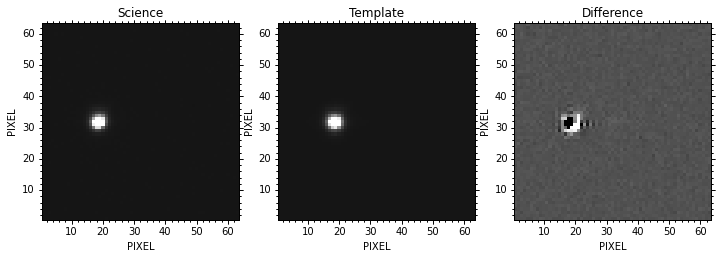

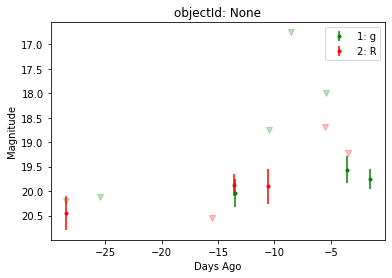

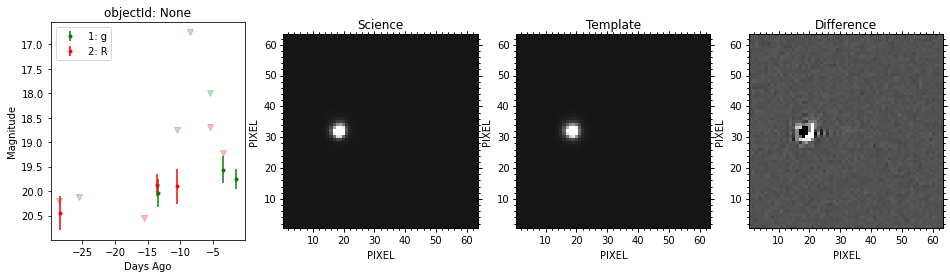

In [ ]:
# Open the files and make some plots
paths = Path(colabpath_noesc).glob('*.avro')
for path in paths:
    with open(path, 'rb') as fin:
        alert_list = [r for r in fastavro.reader(fin)]
    alert_dict = alert_list[0]  # extract the single alert
    
    print(alert_dict['candid'])

    # with warnings.catch_warnings():
        # warnings.simplefilter("ignore")

    pgb.figures.plot_cutouts(alert_dict)  # science, template, and difference 
    
    dflc = pgb.utils.alert_dict_to_dataframe(alert_dict)
    pgb.figures.plot_lightcurve(dflc)
    
    pgb.figures.plot_lightcurve_cutouts(alert_dict)
    
    break

---

# 6) Message streams (Pub/Sub)

__This section is not ready for review.__ 

- Python
  - unpack into dict

---

# 7) Analyze: Using Apache Beam data pipelines (BigQuery and Pub/Sub)

[Apache Beam](https://beam.apache.org/) is an SDK that facilitates writing and executing data pipelines.
The same pipeline can be attached to different sources (e.g., BigQuery and Pub/Sub) and run in batch or streaming mode.
In this tutorial, we will demonstrate these pipelines and the
`pgb_utils` tools that facilitate Beam access to our databases and streams.

Links to more information:
- [Apache Beam Programming Guide](https://beam.apache.org/documentation/programming-guide/) (very useful!)
- [Colab Snippets: Apache Beam](https://colab.research.google.com/github/apache/beam/blob/master/examples/notebooks/get-started/try-apache-beam-py.ipynb)

Note: We will execute pipelines directly in the notebook, but the same pipelines can be executed on a local machine or various distributed systems using different "runners". 
For example, see 
[Apache Flink](https://beam.apache.org/documentation/runners/flink/), 
[Apache Spark](https://beam.apache.org/documentation/runners/spark/), 
[Google Dataflow](https://beam.apache.org/documentation/runners/dataflow/), and
[DirectRunner](https://beam.apache.org/documentation/runners/direct/) (the last being the default, which we use below).
The user sets a few configurations and the runner manages the pipeline execution and the resources (e.g., VM's) and environments needed to run it.

---

## 7a) Query object histories and run a Beam pipeline on the results

In [ ]:
# Define some functions/classes to process our data.
# The structure of these will be discussed later.

# Filter for likely solar system objects
def nearby_ssobject(lcdf):
    """Filter that keeps only objects that are within 5" of a known 
    solar system object. 
    """
    ssdistnr = lcdf['ssdistnr'].mean()
    ssobject_is_near = (ssdistnr > 0) and (ssdistnr < 5)
    return ssobject_is_near


# Calculate the mean magnitude, per passband
class calc_mean_mags(beam.DoFn):
    """Class that wraps our processing function which calculates 
    mean magnitudes per passband ("fid" is filter ID).
    """
    def process(self, lcdf):
        meanmags = lcdf[['fid','magpsf']].groupby('fid').mean()

        # We will write this to a file, so let's format it appropriately.
        # One line per item in the list will be written.
        output = [f"{lcdf.objectId},{fid},{row['magpsf']}" for fid, row in meanmags.iterrows()]

        return output

In [ ]:
# Set pipeline configs

# Create a SQL query statement to retrieve some lightcurve info.
# This query defines the data that will be input to the pipeline.
columns = ['jd', 'fid', 'magpsf', 'sigmapsf', 'ssdistnr']
limit = 2000
query = pgb.bigquery.object_history_sql_statement(columns, limit=limit)  # str

# some keyword args for our pipeline's "read" (input) function
read_args = {
    'query': query, 
    'project': pgb_project_id,  
    'use_standard_sql': True, 
    'gcs_location': 'gs://ardent-cycling-243415_dataflow-test',
        # used as temporary storage for the query results
    # 'validate': True
}

# path to write the results
outputs_prefix = f'{colabpath}/outputs/meanmags'
beam_outputs_prefix = f'{colabpath_noesc}/outputs/meanmags'

In [ ]:
# Run a batch pipeline based on our query statement

with beam.Pipeline() as pipeline:
    (
        pipeline
        # read lightcurves into the pipeline
        | 'Read BigQuery' >> beam.io.ReadFromBigQuery(**read_args)
        # extract the lightcurves into a DataFrame
        | 'Extract Lightcurve df' >> beam.ParDo(pgb.beam.ExtractHistoryDf())
        # filter, keep alerts likely to be a solar system object
        | 'nearby ssobject' >> beam.Filter(nearby_ssobject)
        # do some processing, calculate mean magnitudes per band
        | 'calc mean mags' >> beam.ParDo(calc_mean_mags())
        # save the results to a text file
        | 'Write results' >> beam.io.WriteToText(beam_outputs_prefix)
    )

/usr/local/lib/python3.7/dist-packages/apache_beam/io/gcp/bigquery.py:1881: BeamDeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  temp_location = pcoll.pipeline.options.view_as(


In [ ]:
# Sample the first 20 results, remember there are no ordering guarantees.
run('head -n 20 {}-00000-of-*'.format(outputs_prefix))

>> head -n 20 /content/drive/MyDrive/Colab\ Notebooks/PGB/outputs/meanmags-00000-of-*
ZTF20acpkjpf,1,20.116558074951172
ZTF20acpixou,1,19.511146545410156
ZTF20acpmyej,1,20.21998405456543
ZTF20acpkdqo,1,19.800033569335938
ZTF20acrhznw,1,19.685880661010742
ZTF20acllrep,1,19.79039764404297
ZTF20acplfey,2,19.766691207885742
ZTF20acpjhxb,2,18.87275505065918
ZTF20acrfcfx,2,19.88528060913086
ZTF20acpmdrz,2,19.91057586669922
ZTF20acrevof,2,20.22295379638672
ZTF20acpmdyu,2,20.09497833251953
ZTF20acplaop,2,19.957326889038086
ZTF20acpkwfe,2,20.26532554626465
ZTF20acrfwnn,2,18.97828483581543
ZTF20acpmayv,2,20.083660125732422
ZTF20acqoozt,2,19.659231185913086
ZTF20acrfzws,2,20.51703453063965
ZTF20acpkysn,2,20.35500717163086
ZTF20acpjfag,2,19.82427406311035



In [ ]:
# Functions and classes for the user to experiment with.

#--- Filters
# https://beam.apache.org/documentation/transforms/python/elementwise/filter/
def my_lightcurve_filter(lcdf):
    """
    Args:
        lcdf (pd.DataFrame): a single object's lightcurve data
    Returns:
        keep_lightcurve (bool): True to keep lcdf in the pipeline, 
                                False to filter it out
    """
    # Define your keep_lightcurve bool here
    # for example, we can simply keep everything with an average magpsf > 19
    avg_mag = lcdf['magpsf'].mean()
    keep_lightcurve = avg_mag > 19

    return keep_lightcurve

#--- Functions for processing data
# [provide a link]
class my_alert_function(beam.DoFn):
    def process(self, alertDict):

        # Do your processing here
        # for example, we can simply extract the object and candidate ids
        oid, cid = alertDict['objectId'], alertDict['candid']
        ids = {'objectId': oid, 'candid': cid}

        # Return your output as a list; each element in the list must be
        # of the same type, and will be processed individually by the next 
        # stage in the pipeline.
        return [ids]

---
__The rest of this section is not ready for review.__

In [ ]:
# give them a pipeline that runs the functions in the previous cell

Alert Pipelines

In [ ]:
# Alert pipelines

# example filter for likely solar system objects

def nearby_ssobject(alert):
    candidate = alert['candidate']
    ssobject_is_near = (candidate['ssdistnr'] > 0) and (candidate['ssdistnr'] < 5)
    return ssobject_is_near

# Functions and classes for the user to experiment with.

#--- Filters
# https://beam.apache.org/documentation/transforms/python/elementwise/filter/

# write your own filter
def my_alert_filter(alert):
    """
    Args:
        alert (dict): a single alert
    Returns:
        keep_alert (bool): True to keep the alert, False to filter it out
    """

class my_alert_function(beam.DoFn):
    def process(self, alertDict):

        # Process the alert however you want
        # here we simply extract the object and candidate ids
        oid, cid = alertDict['objectId'], alertDict['candid']
        ids = {'objectId': oid, 'candid': cid}

        # Return your output in a list
        return [ids]


In [ ]:
from apache_beam.options.pipeline_options import PipelineOptions

pipeline_options = PipelineOptions(streaming=True)

In [ ]:
topic = f'projects/{pgb_project_id}/topics/ztf_alert_data'

with beam.Pipeline(options=pipeline_options) as pipeline:
    (
        pipeline
        # read Pub/Sub messages (bytes) into the pipeline
        | 'ReadFromPubSub' >> beam.io.ReadFromPubSub(topic=topic)
        # extract the alert bytes into a dict
        | 'ExtractAlertDict' >> beam.ParDo(pgb.beam.ExtractAlertDict())
        # filter, keep alerts likely to be a solar system object
        | 'nearby_ssobject' >> beam.Filter(nearby_ssobject)
        # do some processing
        | 'my_function' >> beam.ParDo(my_alert_function())
    )

In [ ]:
# Run a Streaming Beam pipeline

topic = 'ztf_alert_data-tjr'

with beam.Pipeline(options=pipeline_options) as pipeline:
    (
        pipeline
        # read Pub/Sub messages (bytes) into the pipeline
        | 'ReadFromPubSub' >> beam.io.ReadFromPubSub(topic=topic)
        # extract the alert bytes into a dict
        | 'ExtractAlertDict' >> beam.ParDo(extractAlertDict()))
        # filter, keep alerts likely to be a solar system object
        | 'nearby_ssobject' >> beam.Filter(nearby_ssobject)
        # do some processing
        | 'my_function' >> beam.ParDo(my_function())
    )

In [ ]:
# Sample the first 20 results, remember there are no ordering guarantees.
run('head -n 20 {}-00000-of-*'.format(outputs_prefix))

---

In [ ]:
#--- Minimal word count (example)
import re

# download some King Lear data
run(f'mkdir -p {colabpath}/data')
run(f'gsutil cp gs://dataflow-samples/shakespeare/kinglear.txt {colabpath}/data/')

# configs
inputs_pattern = f'{colabpath}/data/*'
outputs_prefix = f'{colabpath}/outputs/fromcolab3'

# Running locally in the DirectRunner.
with beam.Pipeline() as pipeline:
  (
      pipeline
      | 'Read lines' >> beam.io.ReadFromText(inputs_pattern)
      | 'Find words' >> beam.FlatMap(lambda line: re.findall(r"[a-zA-Z']+", line))
      | 'Pair words with 1' >> beam.Map(lambda word: (word, 1))
      | 'Group and sum' >> beam.CombinePerKey(sum)
      | 'Format results' >> beam.Map(lambda word_count: str(word_count))
      | 'Write results' >> beam.io.WriteToText(outputs_prefix)
  )

# Sample the first 20 results, remember there are no ordering guarantees.
run('head -n 20 {}-00000-of-*'.format(outputs_prefix))